# Personal Finance Analysis 📊

This notebook performs a **comprehensive analysis of personal spending patterns for the year 2024**, leveraging descriptive statistics, data visualizations, time series analysis, and basic forecasting techniques.

### Project Objectives:
- Gain a clear understanding of where money is being spent.
- Identify key spending categories and patterns.
- Detect anomalies, unusual spikes, and outliers in spending.

Forecast future spending behavior to support better budgeting decisions.

## Contents:
1. Initial Setup  
2. Data Loading & Cleaning  
3. Descriptive Statistics  
4. Visualizations  
5. Time Series Analysis  
6. Statistical Analysis  
7. Summary Report  
8. Export Results 

## 1. Initial Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.stats.weightstats import DescrStatsW
import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 6)

## 2. Data Loading & Cleaning
- Remove rows with missing dates.
- Remove formula cells (`=SUM()`).
- Convert 'Amount' to numeric type.
- Extract 'Month' and 'Year' for time-based analysis.

In [3]:
def load_and_clean_data(filepath):
    df = pd.read_excel(filepath, sheet_name='Expenses in 2024')
    df = df.dropna(subset=['Date'])
    df = df[df['Amount'] != '=SUM(D2:D202)']
    df['Amount'] = pd.to_numeric(df['Amount'])
    df['Month'] = df['Date'].dt.month
    df['Year'] = df['Date'].dt.year
    return df

expense_data = load_and_clean_data('Personal Expense Data.xlsx')

## 3. Descriptive Statistics
This section provides a **numerical summary of your expenses**, including:
- Total spending in 2024.
- Spending by category.
- Monthly spending totals.

In [4]:
def generate_descriptive_stats(df):
    total_spent = df['Amount'].sum()
    category_stats = df.groupby('Category')['Amount'].agg(['sum', 'count', 'mean'])
    category_stats['percentage'] = (category_stats['sum'] / total_spent) * 100
    
    monthly_totals = df.groupby(['Year', 'Month'])['Amount'].sum().reset_index()
    monthly_totals['Month-Year'] = monthly_totals['Month'].astype(str) + '-' + monthly_totals['Year'].astype(str)
    
    return {
        'total_spent': total_spent,
        'category_stats': category_stats,
        'monthly_totals': monthly_totals
    }

descriptive_stats = generate_descriptive_stats(expense_data)

print(f"Total Spending: Rs. {descriptive_stats['total_spent']:,}")
print("\nSpending by Category:")
display(descriptive_stats['category_stats'].sort_values('sum', ascending=False))

Total Spending: Rs. 141,309.0

Spending by Category:


,sum,count,mean,percentage
Category,,,,
Badminton,73200.0,51,1435.294118,51.801371
Shopping,32870.0,10,3287.000000,23.261080
Food,30219.0,106,285.084906,21.385050
Entertainment,4500.0,12,375.000000,3.184511
Transportation,520.0,14,37.142857,0.367988


## 4. Visualizations
**Visual representation of your expenses** provides a clearer understanding.
- **Pie Chart**: Breakdown of spending by category.
- **Line Chart**: Monthly spending trend.

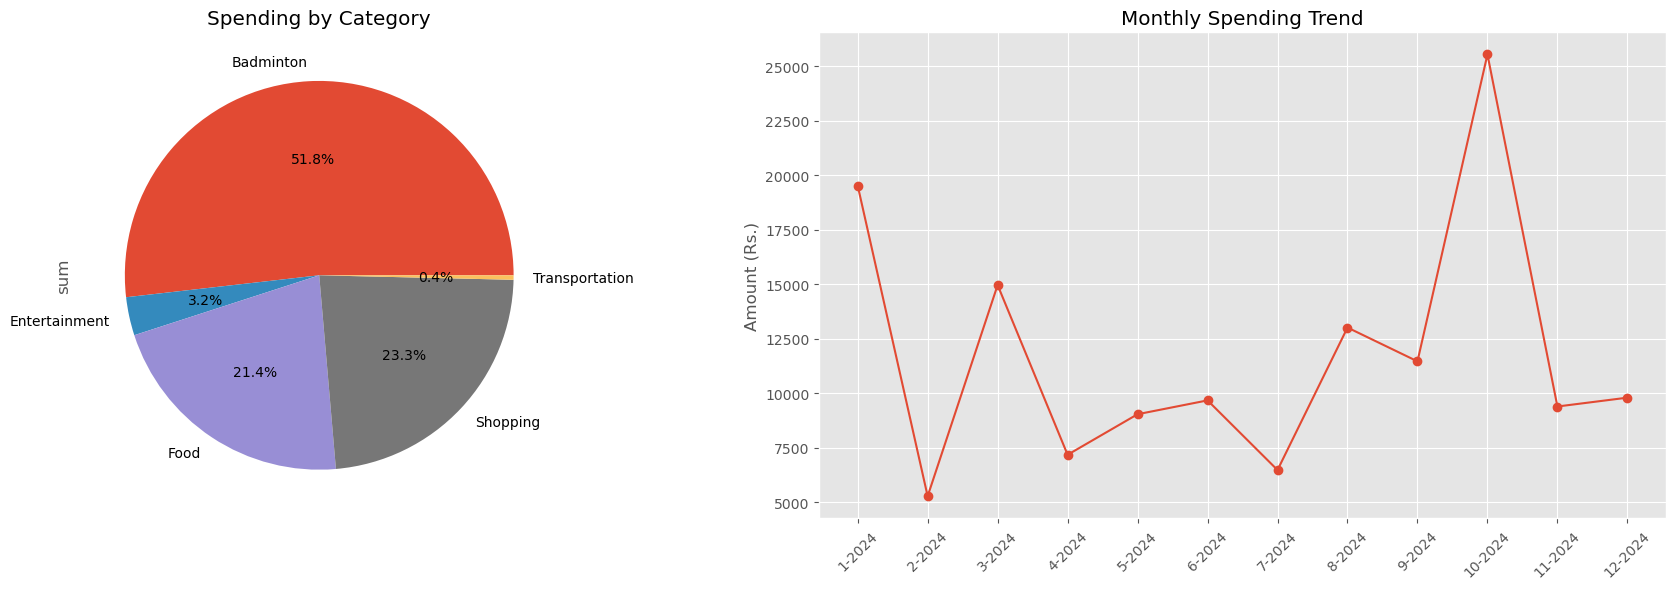

In [5]:
def create_visualizations(stats, df):
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    
    # Pie chart of categories
    stats['category_stats']['sum'].plot.pie(autopct='%1.1f%%', ax=axes[0])
    axes[0].set_title('Spending by Category')
    
    # Monthly trend
    axes[1].plot(stats['monthly_totals']['Month-Year'], stats['monthly_totals']['Amount'], marker='o')
    axes[1].set_title('Monthly Spending Trend')
    axes[1].set_ylabel('Amount (Rs.)')
    axes[1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

create_visualizations(descriptive_stats, expense_data)

## 5. Time Series Analysis
Here, we perform **time series analysis** to identify patterns and forecast future spending.
- **Rolling Average (3 months)** is used to smooth short-term fluctuations and highlight trends.
- This can help in budgeting and planning for upcoming months.

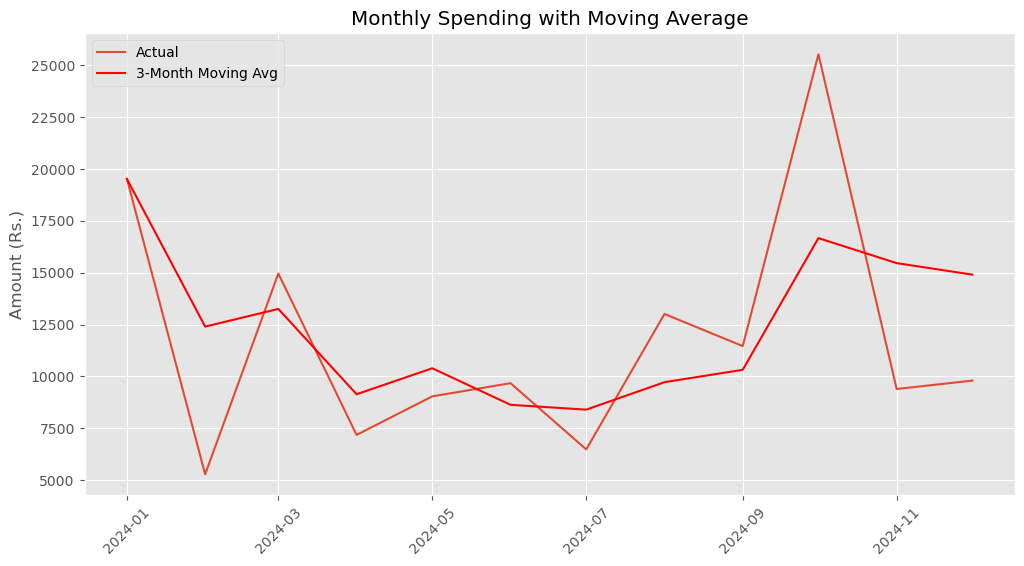

In [6]:
def time_series_analysis(df):
    monthly_totals = df.groupby(['Year', 'Month'])['Amount'].sum().reset_index()
    monthly_totals['Date'] = pd.to_datetime(
        monthly_totals['Year'].astype(str) + '-' + 
        monthly_totals['Month'].astype(str) + '-01',
        format='%Y-%m-%d',
        errors='coerce'
    )
    monthly_totals = monthly_totals.dropna(subset=['Date'])
    monthly_ts = monthly_totals.set_index('Date')['Amount']
    
    # Moving Averages
    moving_avg = monthly_ts.rolling(window=3, min_periods=1).mean()
    
    plt.figure(figsize=(12, 6))
    plt.plot(monthly_ts.index, monthly_ts.values, label='Actual')
    plt.plot(monthly_ts.index, moving_avg.values, label='3-Month Moving Avg', color='red')
    plt.title('Monthly Spending with Moving Average')
    plt.ylabel('Amount (Rs.)')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.show()
    
    return {
        'monthly_data': monthly_ts,
        'moving_avg': moving_avg
    }

ts_results = time_series_analysis(expense_data)

## 6. Statistical Analysis
We perform a statistical examination to:
- Calculate the **confidence interval for non-education spending**, providing a range within which your monthly spending typically falls.
- Detect **outliers using Z-score method** to identify unusual or extreme expenses.

In [7]:
def statistical_analysis(df):
    non_edu = df[df['Category'] != 'Education']
    non_edu_monthly = non_edu.groupby(['Year', 'Month'])['Amount'].sum()
    stats = DescrStatsW(non_edu_monthly)
    ci_low, ci_high = stats.tconfint_mean()
    
    df['Z-score'] = (df['Amount'] - df['Amount'].mean()) / df['Amount'].std()
    outliers = df[abs(df['Z-score']) > 3]
    
    print(f"95% Confidence Interval for Monthly Non-Education Spending: Rs. {ci_low:.2f} - Rs. {ci_high:.2f}")
    
    if not outliers.empty:
        print("\nUnusual Expenses (Outliers):")
        display(outliers[['Date', 'Category', 'Payment Method', 'Amount']].sort_values('Amount', ascending=False))
    
    return {
        'ci_low': ci_low,
        'ci_high': ci_high,
        'outliers': outliers
    }

stat_results = statistical_analysis(expense_data)

95% Confidence Interval for Monthly Non-Education Spending: Rs. 8069.17 - Rs. 15482.33

Unusual Expenses (Outliers):


,Date,Category,Payment Method,Amount
143,2024-10-01 21:11:00,Shopping,Credit,12900.0
20,2024-01-27 13:38:00,Shopping,Credit,5800.0


## 7. Summary Report
This section generates a **concise text-based report** summarizing all key findings:
- Total spending.
- Top 3 spending categories.
- Monthly spending confidence interval.
- List of unusual (outlier) expenses.

In [8]:
def generate_summary_report(stats, stat_results):
    report = f"""
    ====== Personal Finance Analysis Report ======
    
    Key Metrics:
    - Total Spending: Rs. {stats['total_spent']:,}
    
    Top Spending Categories:
    """
    
    top_categories = stats['category_stats'].sort_values('sum', ascending=False).head(3)
    for idx, row in top_categories.iterrows():
        report += f"- {idx}: Rs. {row['sum']:,} ({row['percentage']:.1f}%)\n"
    
    report += f"""
    Monthly Spending Range:
    - 95% Confidence Interval: Rs. {stat_results['ci_low']:.2f} - Rs. {stat_results['ci_high']:.2f}
    """
    
    if not stat_results['outliers'].empty:
        report += "\nUnusual Expenses (Outliers):\n"
        for _, row in stat_results['outliers'].iterrows():
            report += f"- {row['Date'].date()}: {row['Category']} via {row['Payment Method']} - Rs. {row['Amount']:,}\n"
    
    return report

print(generate_summary_report(descriptive_stats, stat_results))


    ====== Personal Finance Analysis Report ======
    
    Key Metrics:
    - Total Spending: Rs. 141,309.0
    
    Top Spending Categories:
    - Badminton: Rs. 73,200.0 (51.8%)
- Shopping: Rs. 32,870.0 (23.3%)
- Food: Rs. 30,219.0 (21.4%)

    Monthly Spending Range:
    - 95% Confidence Interval: Rs. 8069.17 - Rs. 15482.33
    
Unusual Expenses (Outliers):
- 2024-01-27: Shopping via Credit - Rs. 5,800.0
- 2024-10-01: Shopping via Credit - Rs. 12,900.0



## 8. Export Results
Finally, the report is exported as a plain text file `finance_summary.txt` for sharing or archival purposes.

In [9]:
with open("finance_summary.txt", "w") as f:
    f.write(generate_summary_report(descriptive_stats, stat_results))
print("Analysis complete! Report saved as 'finance_summary.txt'")

Analysis complete! Report saved as 'finance_summary.txt'


# 📑 Conclusion

In this personal finance analysis, we thoroughly examined the spending patterns of 2024 using a blend of descriptive statistics, statistical analysis, and time series forecasting techniques. The analysis began with data cleaning and preparation to ensure accuracy, addressing missing and invalid entries.
Descriptive statistics helped identify total spending, category-wise breakdown, and monthly trends. Visualizations, including pie charts and time series plots, provided deeper insights into spending behaviors and seasonal fluctuations.

A time series analysis using moving averages was performed to smooth the data, uncovering underlying spending trends. Additionally, statistical analysis was used to detect unusual expenses, outliers, and calculate confidence intervals for typical monthly spending.
Python libraries such as pandas, matplotlib, and statsmodels were key tools for data manipulation, visualization, and statistical modeling throughout the process.

Overall, this analysis provides actionable insights into my personal financial habits, highlights key spending categories, and lays the groundwork for more informed budgeting and financial planning moving forward.
